## Visualize inference of TAP brain

In [1]:
%matplotlib inline
import sys
sys.path.append('../code')

from plotutils import *

In [2]:
"""
Load data
"""

fname = 'Ns_5_noiseseed_20'
alpha_J, alpha_G = 0, 900
with open('../data/estimates/' + fname + '_' + str(alpha_J) + '_' + str(alpha_G) + '.pkl', 'rb') as f:  
    r_brain, x, y, theta, params, true_estimates, init_estimates, final_estimates = pickle.load(f)
f.close()

use_cuda = True
tapbrain = loadbrain('../data/brains/' + fname, use_cuda)[0]

In [3]:
"""
Extract parameters and variables
"""
Nr, T, B = r_brain.shape
Ns = params['Ns']
Ny = params['Ny']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)
G_init, J_init, U_init, V_init = extractParams(init_estimates['theta_init'], 18, Ns, Ny, Nr)[1:]
G_hat, J_hat, U_hat, V_hat = extractParams(final_estimates['theta_hat'], 18, Ns, Ny, Nr)[1:]

x_tp, r_tp, LL_tp = true_estimates['x_tp'], true_estimates['r_tp'], true_estimates['LL_tp']
x_init, r_init, LL_init = init_estimates['x_init'], init_estimates['r_init'], init_estimates['LL_init']
x_hat, r_hat, LL_hat = final_estimates['x_hat'], final_estimates['r_hat'], final_estimates['LL_hat']

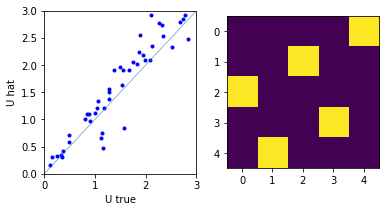

In [4]:
"""
Look at initial estimate of U obtained using embedding
"""
# Estimate the permutation matrix P (need this to resolve permutation ambiguity of ICA)
PermMat = EstimatePermutation_ICA(U,U_init)

# Plot estimate of embedding and permutation matrix
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_init,PermMat).flatten(),'b.')
umax = np.ceil(np.max(np.abs(U)))
ax[0].plot([0,umax],[0,umax],Linewidth=0.5)
ax[0].axis([0,umax,0,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat)
plt.show()

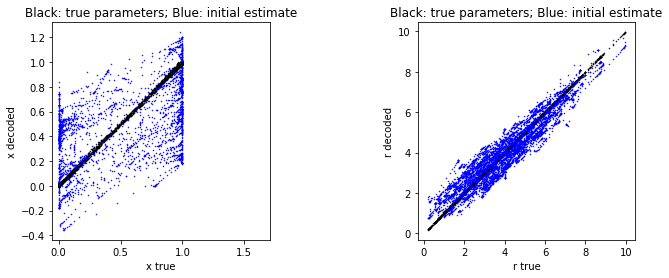

In [5]:
"""
Inferred dynamics pre PFEM
"""
T_st = 6 # discard the first T_st samples for plotting


fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[:,T_st:,:].flatten(), x_tp[:,T_st:,:].flatten(),'k.',markersize=1)
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_init[:,T_st:,:],[Ns,B*(T+1-T_st)])).flatten(),'b.',markersize=1)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')

ax[1].plot(r_brain[:,T_st:,:].flatten(),r_tp[:,T_st:,:].flatten(),'k.',markersize=1)
ax[1].plot(r_brain[:,T_st:,:].flatten(),r_init[:,T_st:,:].flatten(),'b.',markersize=1)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Blue: initial estimate')
ax[1].axis('square')
plt.show()

## Results post PF-EM

Ghat = [ 0.00000000e+00 -3.29463624e-02 -3.66708075e-04 -6.54931657e-01
  7.47655496e-01 -1.62598566e-04  1.64343305e-04 -4.04052201e-04
 -8.65082701e-01  0.00000000e+00 -2.61560427e-03 -1.67870206e-04
 -1.14112499e-04  8.26131927e-05 -9.56735873e-04 -2.12282492e-04
 -4.77392395e-04 -1.12802688e-04]


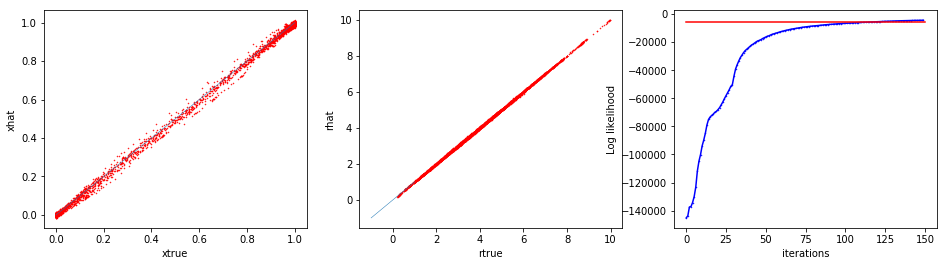

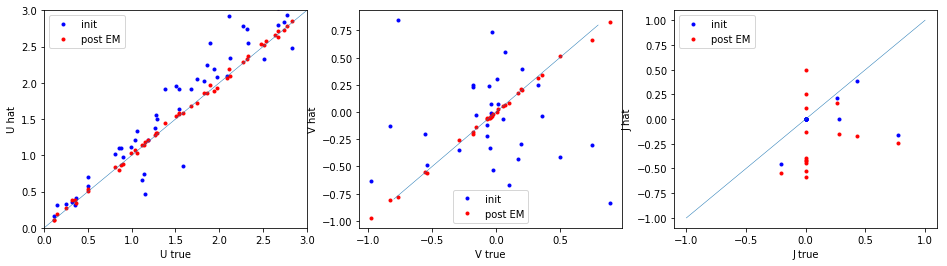

In [6]:
"""
Plotting results post PFEM
"""

# Figure 1
print('Ghat =', G_hat)

fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat[:,T_st:,:],[Ns,B*(T+1-T_st)])).flatten(),'r.',markersize=1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')

ax[1].plot(r_brain[:,T_st:,:].flatten(),r_hat[:,T_st:,:].flatten(),'r.',markersize=1)
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')

LL_Vec = final_estimates['LL_Vec']
EMIters = len(LL_Vec)
ax[2].plot(np.arange(EMIters),LL_Vec,'b.-',markersize=1)
ax[2].plot([0,EMIters],[LL_tp.mean(), LL_tp.mean()],'r')
ax[2].set(xlabel='iterations', ylabel='Log likelihood')

plt.show()

# Figure 2

Jhat = J_hat*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(U.flatten(),np.dot(U_init,PermMat).flatten(),'b.')
ax[0].plot(U.flatten(),np.dot(U_hat,PermMat).flatten(),'r.')
ax[0].plot([0,umax],[0,umax],Linewidth=0.5)
ax[0].axis([0,umax,0,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.flatten(),np.dot(PermMat.T, V_init).flatten(),'b.')
ax[1].plot(V.flatten(),np.dot(PermMat.T, V_hat).flatten(),'r.')
ax[1].plot([-.8,.8],[-.8,.8],linewidth=0.5)
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec(J),JMatToVec(Jinit),'b.')
ax[2].plot(JMatToVec(J),JMatToVec(Jhat),'r.')
ax[2].plot([-1,1],[-1,1],linewidth=0.5)
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

## Use inferred parameters on test data

In [7]:
np.random.seed(42)
torch.manual_seed(42)

In [8]:
T_clip = 20
y_test, x_test, r_brain_test = generatedata(tapbrain, theta, params, use_cuda, B, T, T_clip)

In [9]:
# Run PF using true and inferred parameters
LL_tp_test, x_tp_test, r_tp_test = runparticlefilter(r_brain_test, y_test, theta, params)[0:3]

theta_hat = final_estimates['theta_hat']
LL_hat_test, x_hat_test, r_hat_test = runparticlefilter(r_brain_test, y_test, theta_hat, params)[0:3]

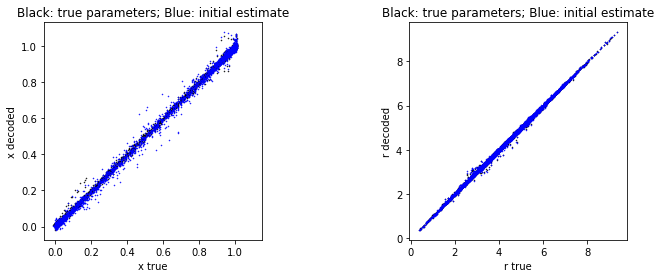

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x_test[:,T_st:,:].flatten(), x_tp_test[:,T_st:,:].flatten(),'k.',markersize=1)
ax[0].plot(x_test[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat_test[:,T_st:,:],[Ns,B*(T+1-T_st)])).flatten(),'b.',markersize=1)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')

ax[1].plot(r_brain_test[:,T_st:,:].flatten(),r_tp_test[:,T_st:,:].flatten(),'k.',markersize=1)
ax[1].plot(r_brain_test[:,T_st:,:].flatten(),r_hat_test[:,T_st:,:].flatten(),'b.',markersize=1)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Blue: initial estimate')
ax[1].axis('square')
plt.show()

[-10328.75707511] [-11322.61671594]


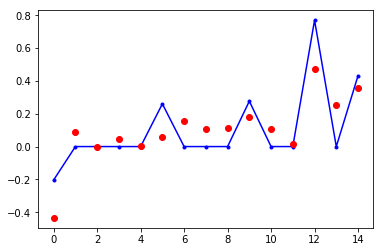

In [11]:
print(LL_tp_test, LL_hat_test)
plt.plot(JMatToVec(J),'b.-')
plt.plot(JMatToVec(Jhat),'ro')

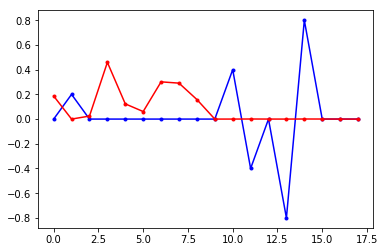

In [46]:
plt.plot(G/10,'b.-')
plt.plot(G_hat,'r.-')


[-10328.75707511] [-11174.73658962]


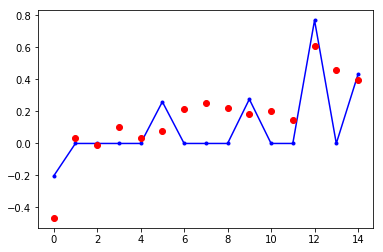

In [22]:
print(LL_tp_test, LL_hat_test)
plt.plot(JMatToVec(J),'b.-')
plt.plot(JMatToVec(Jhat),'ro')

[-10328.75707511] [-11112.34418382]


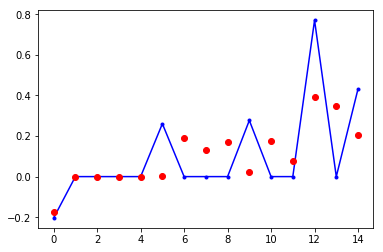

In [34]:
print(LL_tp_test, LL_hat_test)
plt.plot(JMatToVec(J),'b.-')
plt.plot(JMatToVec(Jhat),'ro')

[-10328.75707511] [-11260.59601536]


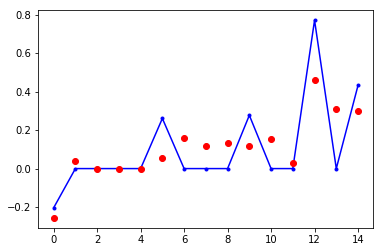

In [45]:
print(LL_tp_test, LL_hat_test)
plt.plot(JMatToVec(J),'b.-')
plt.plot(JMatToVec(Jhat),'ro')